# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [4]:
from commonfunctions import *
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


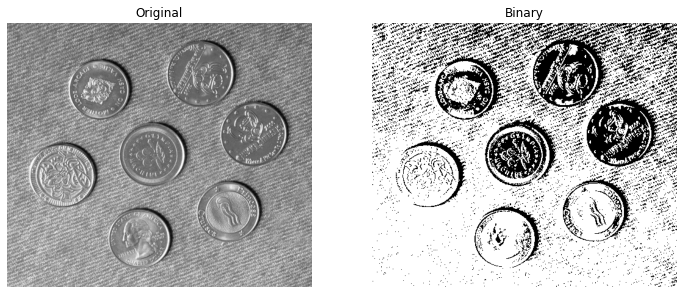

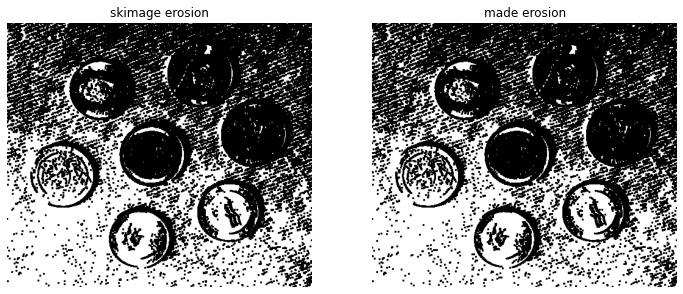

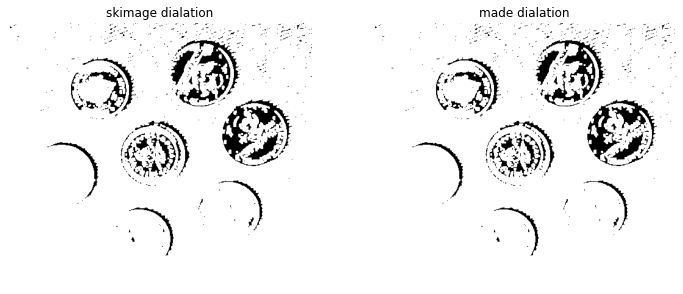

In [125]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''

def binary(img, threshold):
    gray = rgb2gray(img)*255
    bin_img = 1.0*(gray > threshold)
    return bin_img
#the window Size must be an odd number
def erode_dilate(bin_img, se=np.ones((3,3)).astype(np.bool)):
    rows, cols = bin_img.shape
    eroded_shape = (
        rows + se.shape[0] - 1,
        cols + se.shape[1] - 1
    )

    input_img = np.ones(eroded_shape).astype(np.bool)
    input_img[1:rows+1, 1:cols+1] = bin_img.astype(np.bool)

    se = se.astype(np.bool)
    res_img = np.zeros(eroded_shape).astype(np.bool)

    return (res_img, input_img)

def erode(bin_img, se=np.ones((3,3)).astype(np.bool)):
    rows, cols = bin_img.shape
    se_rows, se_cols = se.shape
    eroded_img, input_img = erode_dilate(bin_img, se)

    for row in range(rows):
        for col in range(cols):
            eroded_img[row+1, col+1] = np.min(input_img[row:row+se_rows, col:col+se_cols][se])
    
    return eroded_img[1:rows+1, 1:cols+1]

def dilate(bin_img, se=np.ones((3,3)).astype(np.bool)):
    rows, cols = bin_img.shape
    se_rows, se_cols = se.shape
    delated_img, input_img = erode_dilate(bin_img, se)

    for row in range(rows):
        for col in range(cols):
            delated_img[row+1, col+1] = np.max(input_img[row:row+se_rows, col:col+se_cols][se])
    
    return delated_img[1:rows+1, 1:cols+1]
# def erode(photo,windowSize):
#     temp = np.copy(photo)
#     for i in range (len(temp)):
#         for j in range (len(temp[i])):
#             if i <= windowSize//2 or j <= windowSize//2 or i >= (len(photo) - windowSize//2) or j >= (len(photo[i]) - windowSize//2) :
#                 temp[i][j] = photo[i][j]
#             else :
#                 neighbours = np.zeros(windowSize*windowSize)
#                 value = 1
#                 for k in range(-windowSize//2,windowSize//2):
#                     for m in range (-windowSize//2,windowSize//2):
#                         value = value and photo[i+k][j+m] 
#                 temp[i][j] = value     
#     return temp

# def dilate(photo,windowSize):
#     temp = np.copy(photo)
#     for i in range (len(temp)):
#         for j in range (len(temp[i])):
#             if i <= windowSize//2 or j <= windowSize//2 or i >= (len(photo) - windowSize//2) or j >= (len(photo[i]) - windowSize//2) :
#                 temp[i][j] = photo[i][j]
#             else :
#                 neighbours = np.zeros(windowSize*windowSize)
#                 value = 0
#                 for k in range(-windowSize//2,windowSize//2):
#                     for m in range (-windowSize//2,windowSize//2):
#                         value = value or photo[i+k][j+m] 
#                 temp[i][j] = value     
#     return temp

img = rgb2gray(io.imread('img/coins.jpg'))
kernel = np.ones((3, 3)).astype(np.bool)
# bin_img = np.where(img < 0.5,0,1)
bin_img = binary(img, 128)
made_erosion = erode(bin_img)
made_dialation = dilate(bin_img)
erosion = binary_erosion(bin_img, kernel)
dialation = binary_dilation(bin_img, kernel)
show_images([img, bin_img],['Original', 'Binary'])
show_images([erosion,made_erosion],['skimage erosion','made erosion'])
show_images([dialation,made_dialation],['skimage dialation','made dialation'])

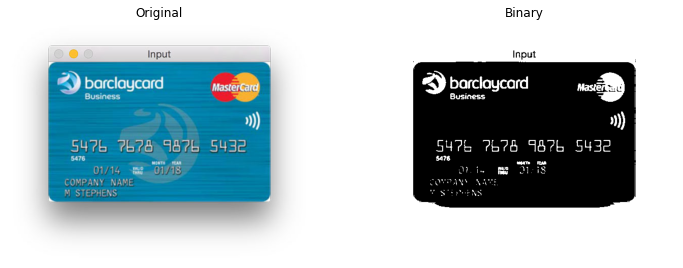

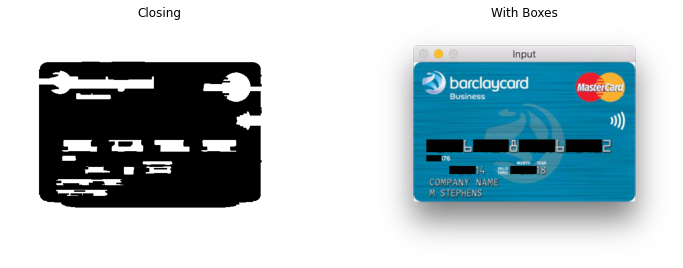

In [129]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
                binary_erosion, binary_dilation
'''
threshold = 153
kernel = np.ones((3, 21)).astype(np.bool)

img = io.imread('img/card.jpg')
img_gray = rgb2gray(img)
img_with_boxes = np.copy(img)
bin_img = binary(img, threshold)
closed_img = dilate(bin_img, kernel)
closed_img = erode(closed_img, kernel)
contours = find_contours(closed_img, 0.8)

bounding_boxes = []
for contour in contours:
    box = [np.min(contour[:, 1]), np.max(contour[:, 1]), np.min(contour[:, 0]), np.max(contour[:, 0])]
    aspect_ratio = (box[1]-box[0])/float(box[3]-box[2])
    if aspect_ratio > 2.5 and aspect_ratio < 3.5:
        bounding_boxes.append(box)
        # h = box[3]-box[2]
        # if h > 20 and h < 25:
        #     bounding_boxes.append(box)
        
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_gray.shape)
    rr = np.array(rr,dtype='int')
    cc = np.array(cc,dtype='int')
    img_with_boxes[rr, cc] = 1 #set color white

show_images([img, bin_img], ['Original', 'Binary'])
show_images([closed_img, img_with_boxes], ['Closing', 'With Boxes'])

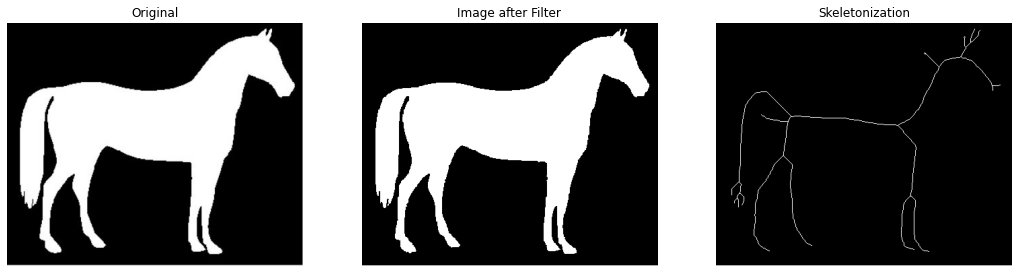

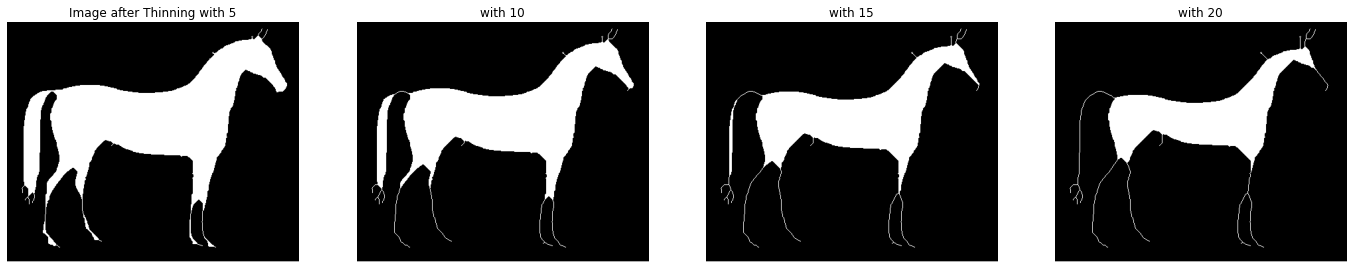

In [130]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
def binarize(image_to_transform, threshold):
    output_image= rgb2gray(image_to_transform);
    for x in range(output_image.shape[0]):
        for y in range(output_image.shape[1]):
            if output_image[x][y]< threshold: 
                output_image[x][y] = 0 
            else:
                output_image[x][y] = 1
    return output_image
img = io.imread('img/horse.jpg')
imgF = binarize(img,0.9)
Skeleton = skeletonize(imgF)
Thinned1 = thin(imgF, 5)
Thinned2 = thin(imgF, 10)
Thinned3 = thin(imgF, 15)
Thinned4 = thin(imgF, 20)
show_images([img, imgF, Skeleton], ['Original', 'Image after Filter', 'Skeletonization'])
show_images([Thinned1, Thinned2, Thinned3, Thinned4], ['Image after Thinning with 5', 'with 10', 'with 15', 'with 20'])